## *********************************************** 

# Program LILY-AVS.ipynb
#### This program does some very basic data analysis on the Automated Vane Shear (AVS) in the LILY database as an example of how to use LILY.
#### Some steps are
* Read the AVS data from the LILY database
* Minor data cleaning: Drop duplicates and NaNs
* Data visualization
    * Plot the shear strength versus depth
    * Contour and make histograms of the shear strength versus depth
* Group the data by principal lithology, simplified lithology, lithology type, lithology subtype, degree of consolidation, and expanded core type
    * Remove outliers base on the mean and standard deviation
* Calculate the mean, median, and statistics for the  undrained shear strength for each of the groups
* Sort the data by the many groupings
* Plot the shear strength versus the groups
* Write the data to a excel file

## Information about the program
* Written in 2023 by Gary Acton
* 2023-09-12: Initial version written by Gary Acton
* 2023-09-27: Acton added comments and minor code cleaning

In [1]:
import warnings

warnings.filterwarnings('ignore')

## *********************************************** 

### The next cell is needed to allow multiple outputs from a single cell.

In [2]:
# Setting to allow all output to be shown in a single cell
# See https://www.roelpeters.be/jupyter-notebooks-how-to-print-multiple-outputs-in-a-cell/
# Without this, only the last output is shown.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Read in the data

In [4]:
!pwd

export: Command not found.
/home/utig5/johna/bhai


In [5]:
# Read in data
import pandas as pd
# Version from June 2023 
# file_MAD  = '/Users/acton/Main/Python/Data_Mining/Data/6_DataLITH/2023/MAD_LITH.csv'
# Newest Version from July 2023 
file_AVS  = 'datasets/AVS_DataLITH.csv'
df = pd.read_csv(file_AVS, low_memory=False)

output_folder = "./output/"

In [6]:
df.info()
print("***************************")
# df.describe(include=[object, int, float])
n = len(df)
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Exp                           2486 non-null   int64  
 1   Site                          2486 non-null   object 
 2   Hole                          2486 non-null   object 
 3   Core                          2486 non-null   int64  
 4   Type                          2486 non-null   object 
 5   Sect                          2486 non-null   object 
 6   A/W                           2486 non-null   object 
 7   Offset (cm)                   2486 non-null   float64
 8   Depth CSF-A (m)               2486 non-null   float64
 9   Depth CSF-B (m)               2486 non-null   float64
 10  Vane shear strength (kN/m^2)  2486 non-null   float64
 11  Max torque angle (deg)        2486 non-null   float64
 12  Penetration direction         2486 non-null   object 
 13  Van

,Exp,Site,Hole,Core,Type,Sect,A/W,Offset (cm),Depth CSF-A (m),Depth CSF-B (m),...,Suffix,Full Lithology,Simplified Lithology,Lithology Type,Degree of Consolidation,Lithology Subtype,Expanded Core Type,Latitude (DD),Longitude (DD),Water Depth (mbsl)
0,334,U1378,B,1,H,2,W,81.0,2.31,2.284,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86
1,334,U1378,B,1,H,3,W,94.0,3.94,3.896,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86
2,334,U1378,B,10,H,4,W,70.0,86.42,86.420,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86
3,334,U1378,B,12,H,3,W,59.0,99.04,99.010,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86
4,334,U1378,B,13,H,4,W,70.0,107.20,107.173,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86


### Drop rows with NaN in main data columns and rename some columns

In [7]:
# If a row is missing one of the following data, then drop those rows of data
df.dropna(subset = ['Vane shear strength (kN/m^2)', 'Max torque angle (deg)', 'Penetration direction','Vane rotation rate (deg/s)', 'Principal'], 
          inplace=True)

# Reset the index or else there will be missing index values, which cause problems in the loops below
df = df.reset_index(drop=True)

n_no_nan = len(df)
print('Number of data before culling: ',n)
print('Number of data after dropping rows with empty values: ',n_no_nan)

# Rename columns for easier use later on
df = df.rename({'Vane shear strength (kN/m^2)': 'Shear Strength'}, axis=1)
df = df.rename({'Latitude (DD)': 'Latitude', 'Longitude (DD)': 'Longitude'}, axis=1)
df = df.rename({'Water Depth (mbsl)': 'Water Depth'}, axis=1)

# df.info()

# If you want to export, use the next line but enter your own path
# df.to_csv("/Users/username/Data/6_DataLITH/AVS_DataLITH_test.csv")

Number of data before culling:  2486
Number of data after dropping rows with empty values:  2485


In [8]:
# Sometimes the data in LIMS is not all that clean. For the AVS data, we noted that the column "Vane rotation rate (deg/s)"
# has some values that are not numbers. At least one cell contain sample ID information, with the string SHLF in it.
# This code snippet removes those rows from the dataframe.
filtered_df = df[~df['Vane rotation rate (deg/s)'].str.contains('SHLF')]
df = filtered_df.copy()
n_no_strange_values = len(df)
print('Number of data after dropping rows with strange values: ',n_no_strange_values)

Number of data after dropping rows with strange values:  2484


In [9]:
df.describe()

,Exp,Core,Offset (cm),Depth CSF-A (m),Depth CSF-B (m),Shear Strength,Max torque angle (deg),Test No.,Latitude,Longitude,Water Depth
count,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2.484000e+03,2484.000000,2484.000000,2474.000000
mean,351.250805,10.627617,65.762279,83.547534,83.456781,56.685354,17.801449,6.380719e+07,15.295798,36.711838,2383.612579
std,11.841903,9.159669,36.933245,75.145372,75.153013,42.070278,9.259750,2.912687e+07,24.779803,116.369710,1316.922115
min,334.000000,1.000000,0.000000,0.230000,0.230000,0.699000,2.000000,2.308029e+07,-39.022005,-147.109975,128.360000
25%,341.000000,4.000000,32.000000,23.608750,23.399500,24.474000,12.000000,4.093447e+07,8.488823,-84.113492,1200.180000
50%,346.000000,8.000000,64.000000,64.960000,64.915000,45.453000,15.000000,5.163771e+07,15.375632,91.605630,2458.550000
75%,362.000000,15.000000,96.000000,122.545000,122.386250,76.687000,22.000000,1.000369e+08,31.789852,139.083008,3666.470000
max,375.000000,62.000000,149.000000,491.720000,491.720000,271.783000,98.000000,1.116081e+08,59.688998,179.245990,4846.670000


### Set data types

In [10]:
# Set the Data Types (dtypes), which is sometimes necessary in the LILY data because the original LIMS data are not always consistent.
# Here I show a couple examples, with only the "Vane rotation rate (deg/s)" actually needing to be changed. 
df['Offset (cm)'] = df['Offset (cm)'].astype(object)
print('Example of changing the offset from numeric to an object. The current data type is', df['Offset (cm)'].dtypes)
df['Vane rotation rate (deg/s)'] = pd.to_numeric(df['Vane rotation rate (deg/s)'],errors = 'coerce')
# Change the data type of the Offset column back to numeric
df['Offset (cm)'] = pd.to_numeric(df['Offset (cm)'],errors = 'coerce')
df.dtypes

Example of changing the offset from numeric to an object. The current data type is object


Exp                             int64
Site                           object
Hole                           object
Core                            int64
Type                           object
Sect                           object
A/W                            object
Offset (cm)                   float64
Depth CSF-A (m)               float64
Depth CSF-B (m)               float64
Shear Strength                float64
Max torque angle (deg)        float64
Penetration direction          object
Vane rotation rate (deg/s)    float64
Timestamp (UTC)                object
Instrument                     object
Text ID                        object
Test No.                        int64
Comments                       object
Prefix                         object
Principal                      object
Suffix                         object
Full Lithology                 object
Simplified Lithology           object
Lithology Type                 object
Degree of Consolidation        object
Lithology Su

In [11]:
# Make a copy of df so as not to have to repeat the above steps every time
dft = df.copy()

### Drop some columns of data and sort by Exp, Site, ...

In [12]:
# Drop columns if you want to simplify the dataset 
dft = dft.drop(['Depth CSF-B (m)','Text ID','Test No.','Comments'], axis=1)
dft.head()


,Exp,Site,Hole,Core,Type,Sect,A/W,Offset (cm),Depth CSF-A (m),Shear Strength,...,Suffix,Full Lithology,Simplified Lithology,Lithology Type,Degree of Consolidation,Lithology Subtype,Expanded Core Type,Latitude,Longitude,Water Depth
0,334,U1378,B,1,H,2,W,81.0,2.31,10.489,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86
1,334,U1378,B,1,H,3,W,94.0,3.94,57.107,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86
2,334,U1378,B,10,H,4,W,70.0,86.42,55.942,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86
3,334,U1378,B,12,H,3,W,59.0,99.04,140.320,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86
4,334,U1378,B,13,H,4,W,70.0,107.20,120.274,...,NaN,silty clay,clay,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86


In [13]:
# Sort the data
dft=dft.sort_values(by=['Exp','Site','Hole','Core','Type','Sect','Offset (cm)'])

### Get some statistical counts of AVS data before and after dropping duplicates

In [14]:
# Drop duplicate values: These can be contacts between lithologies or intervals described with more than one principal lithology.
print("Number of raw data:", n)
print("Number of data after dropping those with missing values:", len(dft))

# List the number of unique lithologies
li = list(dft.Principal.value_counts())
print("Number of unique principal lithologies :", len(li))

# Determine number of duplicates, starting with a few simple examples
df_expeditions = dft.groupby(['Exp']).size().reset_index(name='counts')
df_sites = dft.groupby(['Exp','Site']).size().reset_index(name='counts')

# The next two lines adds a column with the number of duplicates for each interval
df_intervals = dft.copy()
df_intervals['Duplicates'] = dft.groupby(['Exp','Site','Hole','Core','Type','Sect','Offset (cm)'])['Exp'].transform('count')
print("Number of unique intervals before dropping duplicates:", len(df_intervals))

# Drop duplicates with same interval
df_intervals = dft.drop_duplicates(subset=['Exp','Site','Hole','Core','Type','Sect','Offset (cm)'], keep=False)
print("Number of unique intervals after dropping duplicates:", len(df_intervals))
print("Number dropped:", len(dft)-len(df_intervals))

# Drop duplicates with same interval and keep the first of those when the duplicate has the same principal lithology and Shear Strength
df_intervals = dft.drop_duplicates(subset=['Exp','Site','Hole','Core','Type','Sect','Offset (cm)','Principal',
                            'Shear Strength'], keep='first')
# Now drop duplicates from the same interval and with different principal lithologies
df_intervals = df_intervals.drop_duplicates(subset=['Exp','Site','Hole','Core','Type','Sect','Offset (cm)'], keep=False)
print("Number of unique intervals keeping the first of those that")
print("   have the same principal lithology and Shear Strength:", len(df_intervals))
print("Number dropped:", len(dft)-len(df_intervals))

# df_expeditions.head()
# df_intervals.head(8)

# Write to a new CSV file for examination; you only need to change the path
# df_intervals.to_csv('/Users/acton/Desktop/df_intervals.csv', index=False)

Number of raw data: 2486
Number of data after dropping those with missing values: 2484
Number of unique principal lithologies : 54
Number of unique intervals before dropping duplicates: 2484
Number of unique intervals after dropping duplicates: 2434
Number dropped: 50
Number of unique intervals keeping the first of those that
   have the same principal lithology and Shear Strength: 2443
Number dropped: 41


### Save dft_raw, which is df after removing some columns and filtering for NaN values and dropping duplicates

In [15]:
dft = df_intervals.copy()
dft_raw = dft.copy()

### Set the bounds for outliers

In [16]:
# Define bounds for bad data, if there are obvious bounds   
# Shear Strength
avsmin = 0.0
avsmax = 500


# Data visualization of the Raw Data

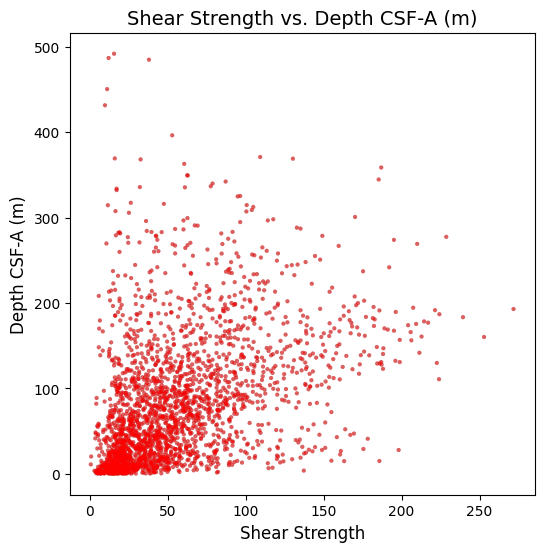

In [17]:
# Plot AVS data from LILY
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

#####################################################################################
plt.style.use('default')
# plt.style.use('classic')

# Set some other plot parameters
parameters = {
    'figure.figsize': (11.5, 6),
    'axes.facecolor' : 'none', # This fills the actual plot area
#    'figure.facecolor' : (1, 1, 0.42),
    'figure.facecolor' : 'None', # This fills the area surrounding the plot
    'savefig.facecolor' : 'None', # This can be used if the saved figure is not using the set values
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'lines.linewidth' : 1.0,
    'lines.markersize' : 3,
    'xtick.labelsize' : 10,
    'ytick.labelsize' : 10,
    'xtick.major.top' : True,
    'xtick.minor.top' : True,
    'legend.fontsize' : 12,
    'legend.title_fontsize' : 'None'
}
plt.rcParams.update(parameters)
#####################################################################################

# plt.rcParams["figure.figsize"] = [7.0, 7.0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.0,6.0], sharex=False, sharey=False)

# Plot whatever you want vs. whatever you want
xstuff = "Shear Strength"
ystuff = "Vane rotation rate (deg/s)"
ystuff = "Max torque angle (deg)"
ystuff = "Depth CSF-A (m)"
title = xstuff + ' vs. ' + ystuff
x = dft_raw[xstuff]
y = dft_raw[ystuff]
ax.scatter(x, y, c='gray', alpha=0.5, edgecolors='none')
x = dft[xstuff]
y = dft[ystuff]

plt.scatter(x, y, c='red', alpha=0.5, edgecolors='none')
ax.set_title(title)
ax.set_xlabel(xstuff)
ax.set_ylabel(ystuff)
t = dft[(dft['Shear Strength'] > avsmax) | (dft['Shear Strength'] < avsmin)]
x = t["Shear Strength"]
y = t[ystuff]
ax.scatter(x, y, c='black', alpha=0.7, edgecolors='none')
# ax.set_xlim([1,4])
# ax.set_ylim([0,100])
plt.show();

<Figure size 1000x1000 with 0 Axes>

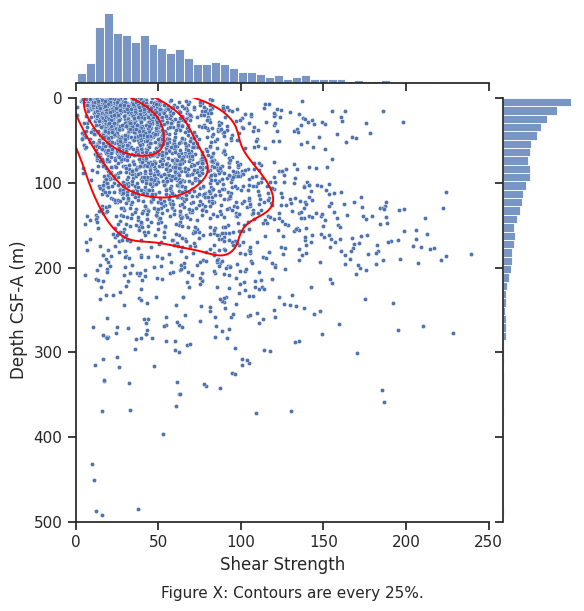

In [18]:
# Seaborn contour plot taken from https://www.python-graph-gallery.com/80-contour-plot-with-seaborn
#     shade : Controls the presence of a shade.
#     cmap : Colormap.
#     bw_adjust : Bandwidth, smoothing parameter.
#     thresh : number in [0, 1], Lowest iso-proportion level at which to draw a contour line.
############################################################################################################
# libraries & dataset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

############################################################################################################
# Set some other plot parameters
 
# set seaborn style
# sns.set(rc={'figure.figsize':(19.0,9.0)}) # This does not work

plt.figure(figsize=(10,10))
# sns.set(rc={'lines.markersize':3.0}) # This is the size of the points in the scatter plot

sns.set(rc={
    'figure.figsize':(12.0,2.0),
    'axes.facecolor' : (0.7, 0.7, 0.7), # This fills the actual plot area
    'axes.labelsize': 12,
    'axes.titlesize': 18,
    'figure.facecolor' : 'None', # This fills the area surrounding the plot, you can use RGB tuples (1, 1, 0.42),
    'xtick.labelsize' : 11,
    'ytick.labelsize' : 11,
    'legend.fontsize' : 12,
    'legend.title_fontsize' : 'None',
    'savefig.facecolor' : 'None',    # This can be used if the saved figure is not using the set values
    'lines.linewidth' : 1.4,
    'lines.markersize' : 3
})

# plt.style.use('default') # Try this to see the difference
sns.set_style("ticks")   # Use one of the sns predefined styles (white, dark, whitegrid, darkgrid, ticks)
############################################################################################################

dfp = dft_raw.copy()
len(dfp)

####### Contour plot ########
g = sns.jointplot(data=dfp, x="Shear Strength", y="Depth CSF-A (m)", xlim=[0.0,250], ylim=[0,500],  marginal_kws=dict(bins=50))
# g = sns.jointplot(data=dfp, x="Shear Strength", y="Depth CSF-A (m)", kind='kde')

# NOTE: Beware of using levels because the are not accurate
g.plot_joint(sns.kdeplot, color='red', levels=[0.25,0.50,0.75], thresh=0.02)
# g.plot_joint(sns.kdeplot, color='red', thresh=0.02)
# g.plot_joint(sns.kdeplot, color='red', thresh=0.05, levels=4, cmap="Reds", fill=True, bw_adjust=.9)

####### Caption ########
caption="Figure X: Contours are every 25%."
plt.gca().invert_yaxis()
plt.figtext(0.5,- 0.01, caption, wrap=True, horizontalalignment='center', fontsize=11)
plt.show();

# dfp = dft.loc[(dft['Consolidation'] == 'unconsolidated') & (dft['Rock_Type'] == 'sedimentary')].copy()

# g.savefig('/Users/acton/Desktop/figX.pdf')
# g.savefig('/Users/acton/Desktop/figX.png', dpi=300)

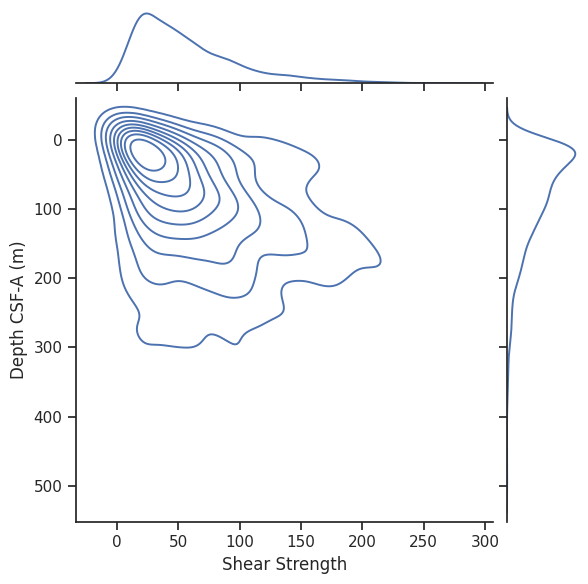

In [19]:
g = sns.jointplot(data=dfp, x="Shear Strength", y="Depth CSF-A (m)", kind='kde')
plt.gca().invert_yaxis()

 # Properties of the data
 
 Histograms illustrate some of the general properties of the data, including the distribution of values for the combined dataset as well as lithologic-dependent differences in distributions, using nannofossil chalk and basalt as examples

## Compute means and statistics for Shear Strength using groupby

The groupby function gets the counts, means, stdev, min, and max of the grouped lithologies.

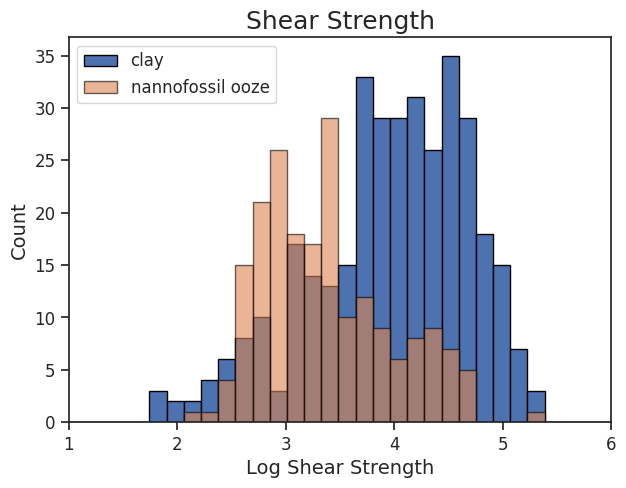

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt

parameters = {
    'figure.figsize': (7, 5),
    'axes.facecolor' : 'none', # This fills the actual plot area
#    'figure.facecolor' : (1, 1, 0.42),
    'figure.facecolor' : 'None', # This fills the area surrounding the plot
    'savefig.facecolor' : 'None', # This can be used if the saved figure is not using the set values
    'axes.labelsize': 14,
    'axes.titlesize': 18,
    'lines.linewidth' : 1.4,
    'lines.markersize' : 4,
    'xtick.labelsize' : 12,
    'ytick.labelsize' : 12,
    'legend.fontsize' : 12,
    'legend.title_fontsize' : 'None'
}
plt.rcParams.update(parameters)

plt.title("Shear Strength")
plt.xlabel("Log Shear Strength")
plt.ylabel("Count")
plt.xlim([1.,6.])

lith = 'clay'
# lith = 'sand'
dfn = dft.loc[(dft['Principal'] == lith) & (dft['Shear Strength'] > 0)].copy()
dfn['Log'] = np.log(dfn['Shear Strength'])
data=dfn['Log']
data.describe()
min_data = 0
max_data = 4 * data.mean()
binwidth=(max_data - min_data)/100
dfn.head(10)
plt.hist(data, edgecolor='black', bins=np.arange(min_data, max_data + binwidth, binwidth), label=lith)

lith = 'nannofossil ooze'
dfn = dft.loc[(dft['Principal'] == lith) & (dft['Shear Strength'] > 0)].copy()
dfn['Log'] = np.log(dfn['Shear Strength'])
data=dfn['Log']
plt.hist(data, edgecolor='black', alpha=0.6, bins=np.arange(min_data, max_data + binwidth, binwidth), label=lith)

# lith = 'diatom ooze'
# lith = 'mud'
# dfn = dft.loc[(dft['Principal'] == lith) & (dft['Shear Strength'] > 0)].copy()
# dfn['Log'] = np.log(dfn['Shear Strength'])
# data=dfn['Log']
# plt.hist(data, edgecolor='black', alpha=0.6, bins=np.arange(min_data, max_data + binwidth, binwidth), label=lith)

plt.legend()
# ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.show();

## Compute mean Log(Shear Strength) for the filtered data, where filtering is by std dev.
### Data are grouped by lithology and then filtered

The groupby function gets the counts, means, stdev, min, and max of the grouped lithologies.

### List of Data Frames
* df: The original data file read in at the beginning of this notebook
* dft_raw: df filtered for NaN values, duplicates, and strange values
* dft: as above with some columns removed
* dfg_grouped: the statistical results for the data for all lithologies
* dfn: a copy of dft that will get modified as filtering occurs
* dfg_filtered: the data after the first filtering
* dfn_filtered: the data after multiple filterings to get the number of data >3 stds to < 0.3%

In [21]:
# Repeat filtering until number of outliers is <= to the expected for 3 standard deviations, which is 0.3%
#     Save the data frame after filtering once, as this is usual sufficient to remove the outliers.

# Create a deep copy of dft called dfn. This allows dfn to be modified without affecting dft.
dfn = dft.copy()
dfn['Log'] = np.log(dfn['Shear Strength'])
# dfn.head()
n_outliers = 9.9  # Set n_outliers to a large value to ensure first loop runs below. After that n_outliers gets reset.
loop = 0

# Set n_outliers to the percent of outliers that you want to remove. Only 0.3% of the data are expected to be 
# three standard deviations away from the mean. 
while n_outliers > 0.1: 
    loop=loop+1

    ############################################################################################################################
    # Here I am adding columns that contain the lithology mean and stdev, which will then allow filtering
    dfn['lith_mean_ss'] = dfn['Log'].groupby(dfn['Principal']).transform('mean')
    dfn['lith_std_ss'] = dfn['Log'].groupby(dfn['Principal']).transform('std')
    # dfn.describe()
    
    print("************** Dataframe dfn for loop ", loop, " **************")
    if loop == 1: 
        dfn.head()

    ############################################################################################################################
    # Setup filtering parameters to remove those data that are more than "multiplier" times the standard deviation
    # away from the mean, where typically multiplier = 3. 
    multiplier=3
    dfn["lith_std_ss"].fillna(99, inplace = True) # Replace all the empty lith_std values with 99
    dfn_filtered = dfn.loc[(dfn['Log'] <  dfn['lith_mean_ss'] + multiplier * dfn['lith_std_ss'] ) & 
        (dfn['Log'] > dfn['lith_mean_ss'] - multiplier * dfn['lith_std_ss'] )]

    # This cell shows how the number of data points is reduced by the filtering
    # print('Length of df  = ', len(df))
    # print('Length of dft = ',len(dft))
    # print('Length of dfg = ',len(dfg))
    print('Length of dfn = ',len(dfn))
    print('Length of dfn_filtered = ',len(dfn_filtered))
    if loop == 1: 
        print('Length of dfg_filtered = ',len(dfn_filtered), " This is the number of data after filtering once.")
    print('Number of outliers for loop ',loop, ' = ',len(dfn) - len(dfn_filtered))
    print('Total number of outliers = ',len(dft) - len(dfn_filtered))
    # The expectation is that 99.7% of the data fall within 3 standard deviations of the mean.
    # This is a good check to see if there are more outliers than expected.
    print('Expected percentage of outliers more than 3 stdev from mean is 0.30%')

    n_outliers = 100*(len(dfn) - len(dfn_filtered))/len(dfn)
    # format the percentage to 2 decimal places
    print(f"Actual percentage of outliers is {n_outliers:.2f}%")
    ############################################################################################################################
    # Note, loop has to be 2 because dfg_filtered is a copy of dfn, which is set to dfn_filtered, from the previous loop, and 
    # then filtered as it passes through the loop again.
    if loop == 2:
        # This is the data after the first filtering
        dfg_filtered = dfn.copy()
        print('**** Number of data points after first filtering = ',len(dfg_filtered)," ****")
        print('')
    dfn = dfn_filtered.copy()
    print('############################################################')
    
print('NEXT LOOP IS', loop)
dfn_filtered.head(20)
len(dfg_filtered)

************** Dataframe dfn for loop  1  **************


,Exp,Site,Hole,Core,Type,Sect,A/W,Offset (cm),Depth CSF-A (m),Shear Strength,...,Lithology Type,Degree of Consolidation,Lithology Subtype,Expanded Core Type,Latitude,Longitude,Water Depth,Log,lith_mean_ss,lith_std_ss
0,334,U1378,B,1,H,2,W,81.0,2.31,10.489,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,2.350327,3.904352,0.796948
1,334,U1378,B,1,H,3,W,94.0,3.94,57.107,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,4.044927,3.904352,0.796948
11,334,U1378,B,2,H,2,W,99.0,7.79,16.549,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,2.806326,3.904352,0.796948
12,334,U1378,B,2,H,3,W,95.0,9.25,20.745,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,3.032305,3.904352,0.796948
15,334,U1378,B,4,H,6,W,91.0,31.82,31.001,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,3.434019,3.904352,0.796948


Length of dfn =  2443
Length of dfn_filtered =  2436
Length of dfg_filtered =  2436  This is the number of data after filtering once.
Number of outliers for loop  1  =  7
Total number of outliers =  7
Expected percentage of outliers more than 3 stdev from mean is 0.30%
Actual percentage of outliers is 0.29%
############################################################
************** Dataframe dfn for loop  2  **************
Length of dfn =  2436
Length of dfn_filtered =  2436
Number of outliers for loop  2  =  0
Total number of outliers =  7
Expected percentage of outliers more than 3 stdev from mean is 0.30%
Actual percentage of outliers is 0.00%
**** Number of data points after first filtering =  2436  ****

############################################################
NEXT LOOP IS 2


,Exp,Site,Hole,Core,Type,Sect,A/W,Offset (cm),Depth CSF-A (m),Shear Strength,...,Lithology Type,Degree of Consolidation,Lithology Subtype,Expanded Core Type,Latitude,Longitude,Water Depth,Log,lith_mean_ss,lith_std_ss
0,334,U1378,B,1,H,2,W,81.0,2.31,10.489,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,2.350327,3.912712,0.785487
1,334,U1378,B,1,H,3,W,94.0,3.94,57.107,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,4.044927,3.912712,0.785487
11,334,U1378,B,2,H,2,W,99.0,7.79,16.549,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,2.806326,3.912712,0.785487
12,334,U1378,B,2,H,3,W,95.0,9.25,20.745,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,3.032305,3.912712,0.785487
15,334,U1378,B,4,H,6,W,91.0,31.82,31.001,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,3.434019,3.912712,0.785487
16,334,U1378,B,5,H,4,W,136.0,39.66,50.347,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,3.918939,3.912712,0.785487
17,334,U1378,B,6,H,2,W,81.0,45.61,31.933,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,3.463640,3.795943,0.401145
18,334,U1378,B,7,H,3,W,20.0,56.00,59.904,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,4.092743,3.912712,0.785487
19,334,U1378,B,8,H,3,W,96.0,64.90,66.431,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,4.196164,3.959511,0.730040
20,334,U1378,B,9,H,3,W,112.0,75.92,47.783,...,sedimentary,unconsolidated,clastic,APC,8.592347,-84.077358,521.86,3.866670,3.912712,0.785487


2436

In [22]:
# This is the data after the first filtering
len(dfg_filtered)
# dfg_filtered.head()
# This is the data after the multiple filtering
len(dfn_filtered)
# dfn_filtered.head()
dfg_filtered.to_excel(output_folder + './junk.xlsx')


2436

2436

ModuleNotFoundError: No module named 'openpyxl'

### Compute Shear Strength for the data filtered once by stdev

In [23]:
# Group by lithology and get statistics

# dfg_filtered is the data after the first filtering
# dfn_filtered is the data after filtering until the number of outliers is <= 0.3%

dftg = dfg_filtered.copy()

# dfg has two columns of information and all data that are in dftg.
# dfg_grouped has the associated statistical parameters.
dfg = dftg.loc[:,['Log','Principal']]
dfg.to_excel(output_folder + 'junk.xlsx')

dothis = True  # Set to True to include simplified lithology, lithology type, etc. in the grouping
if dothis == True:
    # dfg.head()
    dfx = dftg.loc[:,['Log','Simplified Lithology']]
    dfx['Simplified Lithology'] = dfx['Simplified Lithology'] + ": simplified lithology"
    dfx = dfx.rename({'Simplified Lithology':'Principal'}, axis=1)
    dfg = pd.concat([dfg, dfx])
    
    dfx = dftg.loc[:,['Log','Lithology Type']]
    dfx['Lithology Type'] = dfx['Lithology Type'] + ": lithology type"
    dfx = dfx.rename({'Lithology Type':'Principal'}, axis=1)
    dfg = pd.concat([dfg, dfx])
    
    dfx = dftg.loc[:,['Log','Lithology Subtype']]
    dfx['Lithology Subtype'] = dfx['Lithology Subtype'] + ": lithology subtype"
    dfx = dfx.rename({'Lithology Subtype':'Principal'}, axis=1)
    dfg = pd.concat([dfg, dfx])
    
    dfx = dftg.loc[:,['Log','Degree of Consolidation']]
    dfx['Degree of Consolidation'] = dfx['Degree of Consolidation'] + ": consolidation"
    dfx = dfx.rename({'Degree of Consolidation':'Principal'}, axis=1)
    dfg = pd.concat([dfg, dfx])
    
    dfx = dftg.loc[:,['Log','Expanded Core Type']]
    dfx['Expanded Core Type'] = dfx['Expanded Core Type'] + ": coring method"
    dfx = dfx.rename({'Expanded Core Type':'Principal'}, axis=1)
    dfg = pd.concat([dfg, dfx])
    # dfg.tail()

dfg_grouped = dfg.groupby(['Principal']).agg(['count','mean', 'median', 'std', 'min', 'max'])
print(len(dfg))
print(len(dfg_grouped))

# Drop top level column header.
dfg_grouped.columns = dfg_grouped.columns.droplevel(0)

# Rename the columns
dfg_grouped = dfg_grouped.rename({'mean':'mean_ss','median':'median_ss','std':'std_ss','min':'min_ss','max':'max_ss'}, axis=1)

dfg_grouped['stderr_random_ss'] = dfg_grouped['std_ss']/(dfg_grouped['count']**0.5)
# Account for systematic error related to non-Gaussian distribution (e.g. skewness or outliers)
dfg_grouped['stderr_systematic_ss'] = abs(dfg_grouped['mean_ss'] - dfg_grouped['median_ss'])
# Use the next line if you only want the random error
# dfg_grouped['stderr_systematic_g'] = 0.0
dfg_grouped['stderr_total_ss'] = (dfg_grouped['stderr_random_ss']**2 + dfg_grouped['stderr_systematic_ss']**2)**0.5
dfg_grouped['95%_ci_mean_ss'] = 1.96 * dfg_grouped['stderr_total_ss']  # 95% confidence interval

############################################################################################################################
# Get those lithologies that have more than nlots data points)
nlots = 5
dfg_prime = dfg_grouped.loc[(dfg_grouped['count'] > nlots) ]
# print(dfg_grouped.loc[(dfg_grouped['count'] > nlots) ])
print('############################################################')
print('Number of lithologies with more than', nlots,' = ', len(dfg_prime))
dfg_prime.head()
print('############################################################')

ModuleNotFoundError: No module named 'openpyxl'

In [34]:
# List the number of unique lithologies

li = list(dfg_filtered.Principal.value_counts())
print("No.of.unique values :", len(li))
# li = list(dfg_70p.Principal.value_counts())
# print("No.of.unique values :", len(li))

No.of.unique values : 54


In [35]:
# Sort by number of data and compute the standard error and 95% confidence interval

df_sorted = dfg_grouped.sort_values(by=['count'], ascending=False)
# # These are now calculated above
# df_sorted['stderr'] = df_sorted['std_g']/(df_sorted['count']**0.5)
# df_sorted['95%_Conf_Int_Mean'] = 1.96 * df_sorted['stderr']
print(len(df_sorted), len(dftg))
df_sorted
print(df_sorted.info())

90 2436


,count,mean_ss,median_ss,std_ss,min_ss,max_ss,stderr_random_ss,stderr_systematic_ss,stderr_total_ss,95%_ci_mean_ss
Principal,,,,,,,,,,
sedimentary: lithology type,2430,3.767375,3.821792,0.777919,-0.358105,5.605004,0.015781,0.054417,0.056659,0.111051
unconsolidated: consolidation,2299,3.761273,3.806351,0.786398,-0.358105,5.605004,0.016401,0.045079,0.047970,0.094021
APC: coring method,1768,3.729768,3.780113,0.803436,-0.358105,5.605004,0.019108,0.050345,0.053849,0.105544
clastic: lithology subtype,1719,3.776321,3.831940,0.757553,-0.358105,5.432241,0.018272,0.055619,0.058544,0.114746
clay: simplified lithology,668,3.922848,3.957539,0.748086,1.679151,5.432241,0.028944,0.034690,0.045180,0.088552
...,...,...,...,...,...,...,...,...,...,...
mudstone or tuff,1,4.648460,4.648460,NaN,4.648460,4.648460,NaN,0.000000,NaN,NaN
siltstone and mudstone: simplified lithology,1,2.847754,2.847754,NaN,2.847754,2.847754,NaN,0.000000,NaN,NaN
ash/tuff,1,3.216513,3.216513,NaN,3.216513,3.216513,NaN,0.000000,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, sedimentary: lithology type to clayey sand
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   count                 90 non-null     int64  
 1   mean_ss               90 non-null     float64
 2   median_ss             90 non-null     float64
 3   std_ss                77 non-null     float64
 4   min_ss                90 non-null     float64
 5   max_ss                90 non-null     float64
 6   stderr_random_ss      77 non-null     float64
 7   stderr_systematic_ss  90 non-null     float64
 8   stderr_total_ss       77 non-null     float64
 9   95%_ci_mean_ss        77 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 7.7+ KB
None


In [43]:
# Save data 
from datetime import datetime
todays_date = datetime.today().strftime("%Y-%m-%d")
print(todays_date)
filename = "AVS_DataLITH_Shear-Strength_" + todays_date + ".xlsx"
print(filename)
df_sorted.to_excel(output_folder + filename)

2023-09-28
AVS_DataLITH_Shear-Strength_2023-09-28.xlsx


In [44]:
# Sort and remove those with insufficent observations
# del dfs
nlots = 30
dfs = df_sorted.loc[(df_sorted['count'] >= nlots)]
print('Number of lithologies with more than', nlots,' = ', len(dfs))
# dfs

Number of lithologies with more than 30  =  34


In [45]:
# Convert the index column to regular data column
dfs.reset_index(inplace=True)
dfs

,Principal,count,mean_ss,median_ss,std_ss,min_ss,max_ss,stderr_random_ss,stderr_systematic_ss,stderr_total_ss,95%_ci_mean_ss
0,sedimentary: lithology type,2430,3.767375,3.821792,0.777919,-0.358105,5.605004,0.015781,0.054417,0.056659,0.111051
1,unconsolidated: consolidation,2299,3.761273,3.806351,0.786398,-0.358105,5.605004,0.016401,0.045079,0.047970,0.094021
2,APC: coring method,1768,3.729768,3.780113,0.803436,-0.358105,5.605004,0.019108,0.050345,0.053849,0.105544
3,clastic: lithology subtype,1719,3.776321,3.831940,0.757553,-0.358105,5.432241,0.018272,0.055619,0.058544,0.114746
4,clay: simplified lithology,668,3.922848,3.957539,0.748086,1.679151,5.432241,0.028944,0.034690,0.045180,0.088552
5,biogenic: lithology subtype,665,3.751125,3.742160,0.839397,1.316140,5.605004,0.032550,0.008965,0.033762,0.066174
6,ooze: simplified lithology,661,3.755644,3.753145,0.839651,1.316140,5.605004,0.032659,0.002499,0.032754,0.064198
7,mud: simplified lithology,639,3.749194,3.790691,0.682777,1.634716,5.288908,0.027010,0.041498,0.049514,0.097047
8,HLAPC: coring method,428,3.932492,3.968611,0.677659,1.762502,5.347174,0.032756,0.036119,0.048760,0.095570
9,mud,408,3.665113,3.667630,0.724035,1.634716,5.204243,0.035845,0.002517,0.035933,0.070429


In [46]:
dfs = dfs.sort_values(by=['mean_ss'], ascending=False)
dfs

,Principal,count,mean_ss,median_ss,std_ss,min_ss,max_ss,stderr_random_ss,stderr_systematic_ss,stderr_total_ss,95%_ci_mean_ss
22,diatom ooze,62,4.181882,4.263788,0.570767,2.874412,5.347174,0.072487,0.081906,0.109376,0.214376
25,silt/siltstone and mud/mudstone: simplified li...,51,4.065608,4.156803,0.513808,2.586711,4.995718,0.071948,0.091195,0.116159,0.227672
24,interbedded silt/siltstone and mud/mudstone,51,4.065608,4.156803,0.513808,2.586711,4.995718,0.071948,0.091195,0.116159,0.227672
18,indeterminate: consolidation,88,3.959821,4.075068,0.581500,2.281361,5.046459,0.061988,0.115246,0.130859,0.256485
11,clay,352,3.959511,4.051026,0.730040,1.801710,5.353814,0.038911,0.091515,0.099443,0.194909
8,HLAPC: coring method,428,3.932492,3.968611,0.677659,1.762502,5.347174,0.032756,0.036119,0.048760,0.095570
10,carbonate ooze,359,3.931103,4.077063,0.909718,1.316140,5.605004,0.048013,0.145959,0.153653,0.301161
4,clay: simplified lithology,668,3.922848,3.957539,0.748086,1.679151,5.432241,0.028944,0.034690,0.045180,0.088552
13,pebbly mud,204,3.921745,3.921258,0.555541,2.777763,5.288908,0.038896,0.000487,0.038899,0.076241
12,silty clay,289,3.912712,3.918939,0.785487,1.679151,5.432241,0.046205,0.006227,0.046623,0.091381


In [47]:
# # Remove the Principal lithologies with "interbedded" in the name along with a few others to make the plot simplier.
# dfs_no_interbedded = dfs[~dfs['Principal'].str.contains('interbedded')]
# dfs_no_interbedded = dfs_no_interbedded.loc[(dfs_no_interbedded ['Principal'] != 'ooze') & 
#                                             (dfs_no_interbedded ['Principal'] != 'fine sand') &
#                                             (dfs_no_interbedded ['Principal'] != 'fine sandstone') &
#                                             (dfs_no_interbedded ['Principal'] != 'very find sand') &
#                                             (dfs_no_interbedded ['Principal'] != 'silty mud') &
#                                             (dfs_no_interbedded ['Principal'] != 'nannofossil mud') &
#                                             (dfs_no_interbedded ['Principal'] != 'pebbly mud') &
#                                             (dfs_no_interbedded ['Principal'] != 'medium to coarse sandstone')]
# print(len(dfs_no_interbedded))

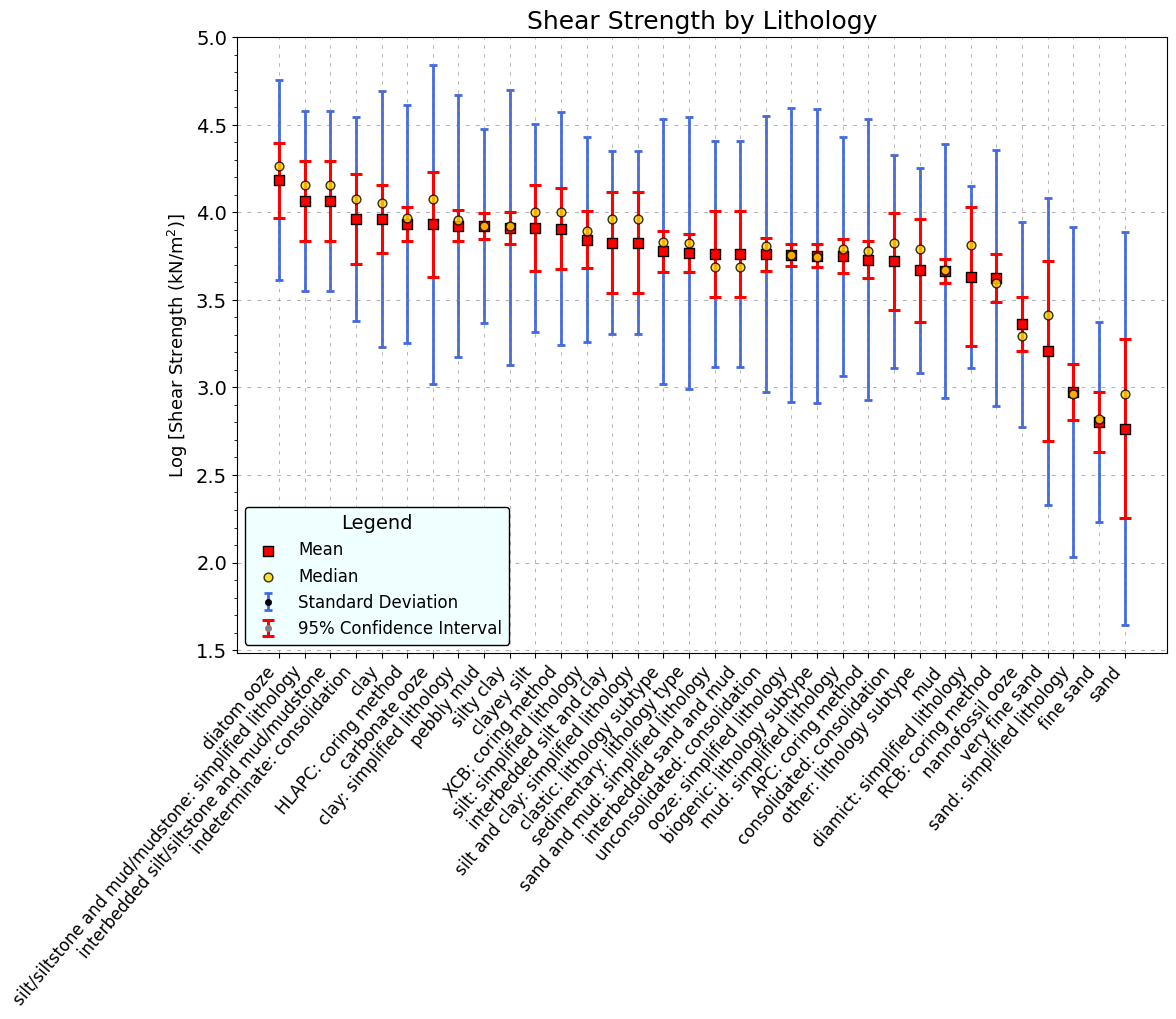

In [48]:
# Dot plot with error bars
import matplotlib.ticker as ticker
#####################################################################################
plt.style.use('default')
# plt.style.use('classic')

# Set some other plot parameters
parameters = {
    'figure.figsize': (12, 8),
    'axes.facecolor' : 'none', # This fills the actual plot area
#    'figure.facecolor' : (1, 1, 0.42),
    'figure.facecolor' : 'None', # This fills the area surrounding the plot
    'savefig.facecolor' : 'None', # This can be used if the saved figure is not using the set values
    'axes.labelsize': 13,
    'axes.titlesize': 18,
    'lines.linewidth' : 1.4,
    'lines.markersize' : 4,
    'xtick.labelsize' : 12,
    'ytick.labelsize' : 14,
    'legend.fontsize' : 12,
    'legend.title_fontsize' : 'None'
}
plt.rcParams.update(parameters)
plt.rc('font', size=15)                  # controls default text sizes (particularly, the font size of the axis labels)

# Linestyles for grid are at https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
#plt.grid(True)
# plt.grid(axis="x", color="gray", alpha=.3, linewidth=0.7, linestyle="dashed")
plt.grid(axis="x", color="gray", alpha=.8, linewidth=0.5, linestyle=(0, (5, 8)))
# plt.grid(axis="x", color="gray", alpha=.8, linewidth=0.7, linestyle='solid')
# plt.grid(axis="y", color="green", alpha=.8, linewidth=1, linestyle="dotted")
plt.grid(axis="y", color="gray", alpha=.8, linewidth=0.55, linestyle=(0, (5, 8)))
# plt.grid(axis="y", color="gray", alpha=.8, linewidth=0.5, linestyle='solid')
# plt.grid(axis="x", color="gray", alpha=.8, linewidth=0.7)
# plt.grid(axis="y", color="green", alpha=.8, linewidth=0.7)
#####################################################################################

# dfp = dfs_no_interbedded
dfp = dfs
x=dfp['Principal']
y=dfp['mean_ss']
y_error=dfp['std_ss']
# Function to avoid overlapping

ax = plt.subplot()
plt.setp(ax.get_xticklabels(), rotation=50, ha='right')
#plt.xticks(rotation=50)
ax.set_yticks(np.arange(2, max(y+0.1), .1))

plt.errorbar(x, y, yerr = y_error,fmt='o',ecolor = 'royalblue',color='black', linewidth = 2, capsize=3, capthick=2, zorder=1, label='Standard Deviation')
y_error2=dfp['95%_ci_mean_ss']
plt.errorbar(x, y, yerr = y_error2,fmt='o',ecolor = 'red', color='gray', elinewidth = 2.2, capsize=4, capthick=2.2, zorder=2, label='95% Confidence Interval')

y=dfp['mean_ss']
plt.scatter(x, y, marker='s', s=60, c="red", alpha=1.0, edgecolors='black', zorder=3, label='Mean')
y=dfp['median_ss']
plt.scatter(x, y, marker='o', s=40, c="gold", alpha=0.8, edgecolors='black', zorder=3, label='Median')

# plt.legend(loc='best', bbox_to_anchor=(0.73, 0.45, 0.5, 0.5), frameon=True, title='Legend', 
#            facecolor='azure', framealpha=1.0, edgecolor='black', title_fontsize=14)
plt.legend(loc='best',frameon=True, title='Legend', facecolor='azure', framealpha=1.0, edgecolor='black', title_fontsize=14)
plt.title("Shear Strength by Lithology")
plt.ylabel("Log [Shear Strength (kN/m$^2$)]")

#####################################################################################
# Set the tick marks (from ChatGPT)
# Customize the tick marks on the y-axis
y_major_ticks = ticker.MultipleLocator(0.5)
y_minor_ticks = ticker.MultipleLocator(0.1)
ax.yaxis.set_major_locator(y_major_ticks)
ax.yaxis.set_minor_locator(y_minor_ticks)

#####################################################################################

plt.savefig(output_folder + 'figure-shear-strength.svg')
plt.show();

## Save the data

In [49]:
# Save data 
from datetime import datetime
todays_date = datetime.today().strftime("%Y-%m-%d")
print(todays_date)
filename = "AVS_DataLITH_clean_" + todays_date + ".xlsx"
print(filename)
dfg_filtered.to_excel(output_folder + filename, index=False)

2023-09-28
AVS_DataLITH_clean_2023-09-28.xlsx


# The End